In [1]:
from pandas import DataFrame, concat
from pandas import read_csv
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Dense
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

/home/sudaraka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset = read_csv('with_timestamp.csv', header=0, index_col=0)
dataset.drop(["@timestamp", "anomaly"], axis=1, inplace=True)
dataset.head()

,system.cpu.idle.pct,system.cpu.iowait.pct,system.cpu.softirq.pct,system.cpu.system.pct,system.cpu.total.pct,system.cpu.user.pct,system.diskio_sda.iostat.await,system.diskio_sda.iostat.busy,system.diskio_sda.iostat.queue.avg_size,system.diskio_sda.iostat.read.request.merges_per_sec,...,jolokia.metrics.threading.thread_count,system.load.1,system.load.15,system.load.5,system.load.norm.1,system.load.norm.15,system.load.norm.5,system.memory.actual.used.pct,system.memory.swap.used.pct,system.memory.used.pct
0,3.5818,0.0474,0.0312,0.1058,0.4182,0.2338,0.698,12.601,0.165,0.0,...,995,0.68,0.97,1.00,0.170,0.243,0.250,0.6904,0.0,0.9620
1,3.5080,0.0934,0.0271,0.1054,0.4920,0.2661,0.572,11.104,0.137,0.0,...,995,0.58,0.96,0.97,0.145,0.240,0.243,0.6903,0.0,0.9626
2,3.5337,0.1136,0.0291,0.1025,0.4663,0.2211,0.572,11.104,0.137,0.0,...,995,0.65,0.96,0.97,0.163,0.240,0.243,0.6904,0.0,0.9628
3,3.5742,0.0503,0.0201,0.0916,0.4258,0.2637,0.572,11.104,0.137,0.0,...,995,0.68,0.95,0.95,0.170,0.238,0.238,0.6903,0.0,0.9635
4,3.5454,0.0705,0.0268,0.1051,0.4546,0.2522,0.572,11.104,0.137,0.0,...,995,0.68,0.95,0.95,0.170,0.238,0.238,0.6905,0.0,0.9638


## Normalizing Data

In [3]:
dataset[dataset.columns] = StandardScaler().fit_transform(dataset)

## Shifting the dataset
shifting only one minute

In [4]:
dataset_shifted = dataset.shift(-6)
dataset = dataset.iloc[:-6]
dataset_shifted = dataset_shifted.iloc[:-6]

## Spliting the dataset 
Ratio - 80 : 20

In [5]:
train = dataset.shape[0] * 2 // 10
    
train_dataset = dataset.iloc[:-train]
train_dataset_shifted = dataset_shifted.iloc[:-train]

test_dataset = dataset.iloc[-train:]
test_dataset_shifted = dataset_shifted.iloc[-train:]

In [6]:
train_dataset = train_dataset.values.reshape((train_dataset.shape[0], 1, train_dataset.shape[1]))
print(train_dataset_shifted.shape)

(39996, 39)


## Training Models

### Feature Set 1
- system.cpu.iowait.pct'
- system.diskio_sda.iostat.await'
- system.diskio_sda.iostat.busy'
- system.diskio_sda.iostat.queue.avg_size'
- system.diskio_sda.iostat.read.request.merges_per_sec'
- system.diskio_sda.iostat.read.request.per_sec'
- system.diskio_sda.iostat.request.avg_size'
- system.diskio_sda.iostat.service_time'
- system.diskio_sda.iostat.write.request.merges_per_sec'
- system.diskio_sda.iostat.write.request.per_sec'
- system.diskio_sda2.iostat.await'
- system.diskio_sda2.iostat.busy'
- system.diskio_sda2.iostat.queue.avg_size'
- system.diskio_sda2.iostat.read.request.merges_per_sec'
- system.diskio_sda2.iostat.read.request.per_sec'
- system.diskio_sda2.iostat.request.avg_size'
- system.diskio_sda2.iostat.service_time'
- system.diskio_sda2.iostat.write.request.merges_per_sec'
- system.diskio_sda2.iostat.write.request.per_sec'

In [7]:
train_dataset_shifted_1 = train_dataset_shifted[[
    'system.cpu.iowait.pct',
    'system.diskio_sda.iostat.await',
    'system.diskio_sda.iostat.busy',
    'system.diskio_sda.iostat.queue.avg_size',
    'system.diskio_sda.iostat.read.request.merges_per_sec',
    'system.diskio_sda.iostat.read.request.per_sec',
    'system.diskio_sda.iostat.request.avg_size',
    'system.diskio_sda.iostat.service_time',
    'system.diskio_sda.iostat.write.request.merges_per_sec',
    'system.diskio_sda.iostat.write.request.per_sec',
    'system.diskio_sda2.iostat.await',
    'system.diskio_sda2.iostat.busy',
    'system.diskio_sda2.iostat.queue.avg_size',
    'system.diskio_sda2.iostat.read.request.merges_per_sec',
    'system.diskio_sda2.iostat.read.request.per_sec',
    'system.diskio_sda2.iostat.request.avg_size',
    'system.diskio_sda2.iostat.service_time',
    'system.diskio_sda2.iostat.write.request.merges_per_sec',
    'system.diskio_sda2.iostat.write.request.per_sec']]
train_dataset_shifted_1.head()

,system.cpu.iowait.pct,system.diskio_sda.iostat.await,system.diskio_sda.iostat.busy,system.diskio_sda.iostat.queue.avg_size,system.diskio_sda.iostat.read.request.merges_per_sec,system.diskio_sda.iostat.read.request.per_sec,system.diskio_sda.iostat.request.avg_size,system.diskio_sda.iostat.service_time,system.diskio_sda.iostat.write.request.merges_per_sec,system.diskio_sda.iostat.write.request.per_sec,system.diskio_sda2.iostat.await,system.diskio_sda2.iostat.busy,system.diskio_sda2.iostat.queue.avg_size,system.diskio_sda2.iostat.read.request.merges_per_sec,system.diskio_sda2.iostat.read.request.per_sec,system.diskio_sda2.iostat.request.avg_size,system.diskio_sda2.iostat.service_time,system.diskio_sda2.iostat.write.request.merges_per_sec,system.diskio_sda2.iostat.write.request.per_sec
0,-0.126642,-0.145439,-0.200244,-0.120378,-0.036651,-0.060667,-0.145092,-0.192760,-0.060835,1.143935,-0.132459,-0.200173,-0.121455,-0.036656,-0.060681,-0.130237,-0.192853,-0.060835,1.151815
1,-0.001994,-0.116965,-0.058010,-0.072736,-0.036651,-0.053136,-0.307858,-0.132323,-0.055074,1.011877,-0.107455,-0.057741,-0.073145,-0.036656,-0.053127,-0.269181,-0.132691,-0.055074,1.019195
2,-0.070217,-0.116965,-0.058010,-0.072736,-0.036651,-0.053136,-0.307858,-0.132323,-0.055074,1.011877,-0.107455,-0.057741,-0.073145,-0.036656,-0.053127,-0.269181,-0.132691,-0.055074,1.019195
3,0.123168,-0.116965,-0.058010,-0.072736,-0.036651,-0.053136,-0.307858,-0.132323,-0.055074,1.011877,-0.107455,-0.057741,-0.073145,-0.036656,-0.053127,-0.269181,-0.132691,-0.055074,1.019195
4,-0.060471,-0.116965,-0.058010,-0.072736,-0.036651,-0.053136,-0.307858,-0.132323,-0.055074,1.011877,-0.107455,-0.057741,-0.073145,-0.036656,-0.053127,-0.269181,-0.132691,-0.055074,1.019195


In [8]:
model_gru_1 = Sequential()
model_gru_1.add(GRU(10, input_shape=(1, train_dataset_shifted.shape[1])))
model_gru_1.add(Dense(19))
model_gru_1.compile(loss='mae', optimizer='adam')

model_gru_1.fit(train_dataset, train_dataset_shifted_1, verbose=2, shuffle=False)

Epoch 1/1
 - 8s - loss: 0.1528


### Feature Set 2
- system.cpu.total.pct'
- system.cpu.user.pct'

In [9]:
train_dataset_shifted_2 = train_dataset_shifted[[
    'system.cpu.total.pct',
    'system.cpu.user.pct']]

train_dataset_shifted_2.head()

,system.cpu.total.pct,system.cpu.user.pct
0,-0.282538,-0.241286
1,-0.235823,-0.235949
2,-0.259415,-0.255883
3,-0.148017,-0.187449
4,-0.247541,-0.233281


In [10]:
model_gru_2 = Sequential()
model_gru_2.add(GRU(10, input_shape=(1, train_dataset_shifted.shape[1])))
model_gru_2.add(Dense(2))
model_gru_2.compile(loss='mae', optimizer='adam')

model_gru_2.fit(train_dataset, train_dataset_shifted_2, verbose=2, shuffle=False)

Epoch 1/1
 - 5s - loss: 0.1920


### Feature Set 3
- jolokia.metrics.memory.heap_memory_usage.committed'
- jolokia.metrics.memory.heap_memory_usage.max'

In [11]:
train_dataset_shifted_3 = train_dataset_shifted[[
    'jolokia.metrics.memory.heap_memory_usage.committed',
    'jolokia.metrics.memory.heap_memory_usage.max']]

train_dataset_shifted_3.head()

,jolokia.metrics.memory.heap_memory_usage.committed,jolokia.metrics.memory.heap_memory_usage.max
0,-0.360082,-0.360082
1,-0.005949,-0.005949
2,-0.005949,-0.005949
3,-0.005949,-0.005949
4,-0.005949,-0.005949


In [12]:
model_gru_3 = Sequential()
model_gru_3.add(GRU(10, input_shape=(1, train_dataset_shifted.shape[1])))
model_gru_3.add(Dense(2))
model_gru_3.compile(loss='mae', optimizer='adam')

model_gru_3.fit(train_dataset, train_dataset_shifted_3, verbose=2, shuffle=False)

Epoch 1/1
 - 7s - loss: 0.3907


### Feature Set 4
- system.load.1'
- system.load.15'
- system.load.5'
- system.load.norm.1'
- system.load.norm.15'
- system.load.norm.5'

In [13]:
train_dataset_shifted_4 = train_dataset_shifted[[
    'system.load.1',
    'system.load.15',
    'system.load.5',
    'system.load.norm.1',
    'system.load.norm.15',
    'system.load.norm.5']]

train_dataset_shifted_4.head()

,system.load.1,system.load.15,system.load.5,system.load.norm.1,system.load.norm.15,system.load.norm.5
0,-0.154500,-0.134027,-0.134026,-0.156827,-0.136740,-0.136533
1,-0.150089,-0.134027,-0.134026,-0.152417,-0.136740,-0.136533
2,-0.142368,-0.133203,-0.132818,-0.144699,-0.136080,-0.135325
3,-0.085016,-0.127432,-0.119526,-0.087363,-0.130145,-0.122034
4,-0.085016,-0.127432,-0.119526,-0.087363,-0.130145,-0.122034


In [14]:
model_gru_4 = Sequential()
model_gru_4.add(GRU(10, input_shape=(1, train_dataset_shifted.shape[1])))
model_gru_4.add(Dense(6))
model_gru_4.compile(loss='mae', optimizer='adam')

model_gru_4.fit(train_dataset, train_dataset_shifted_4, verbose=2, shuffle=False)

Epoch 1/1
 - 5s - loss: 0.1287


### Feature Set 5
- system.cpu.idle.pct'
- system.cpu.softirq.pct'
- system.cpu.system.pct'
- jolokia.metrics.memory.heap_memory_usage.used'
- jolokia.metrics.memory.non_heap_memory_usage.used'
- jolokia.metrics.threading.daemon_thread_count'
- jolokia.metrics.threading.thread_count'
- system.memory.actual.used.pct'
- system.memory.swap.used.pct'
- system.memory.used.pct'

In [15]:
train_dataset_shifted_5 = train_dataset_shifted[[
    'system.cpu.idle.pct',
    'system.cpu.softirq.pct',
    'system.cpu.system.pct',
    'jolokia.metrics.memory.heap_memory_usage.used',
    'jolokia.metrics.memory.non_heap_memory_usage.used',
    'jolokia.metrics.threading.daemon_thread_count',
    'jolokia.metrics.threading.thread_count',
    'system.memory.actual.used.pct',
    'system.memory.swap.used.pct',
    'system.memory.used.pct']]

train_dataset_shifted_5.head()

,system.cpu.idle.pct,system.cpu.softirq.pct,system.cpu.system.pct,jolokia.metrics.memory.heap_memory_usage.used,jolokia.metrics.memory.non_heap_memory_usage.used,jolokia.metrics.threading.daemon_thread_count,jolokia.metrics.threading.thread_count,system.memory.actual.used.pct,system.memory.swap.used.pct,system.memory.used.pct
0,0.282538,0.141898,-0.245786,1.185044,-1.669443,-0.793713,-1.115556,-1.046841,-0.078425,-0.263898
1,0.235823,0.414459,-0.151090,-0.705681,-1.669919,-0.960973,-1.122619,-1.042371,-0.078425,-0.212167
2,0.259415,0.885248,0.615090,-0.705681,-1.669919,-0.960973,-1.122619,-1.037900,-0.078425,-0.189997
3,0.148017,-0.155442,0.124390,-0.705681,-1.669919,-0.960973,-1.122619,-1.042371,-0.078425,-0.138265
4,0.247541,0.216233,0.098564,-0.705681,-1.669919,-0.960973,-1.122619,-1.037900,-0.078425,-0.116095


In [16]:
model_gru_5 = Sequential()
model_gru_5.add(GRU(10, input_shape=(1, train_dataset_shifted.shape[1])))
model_gru_5.add(Dense(10))
model_gru_5.compile(loss='mae', optimizer='adam')

model_gru_5.fit(train_dataset, train_dataset_shifted_5, verbose=2, shuffle=False)

Epoch 1/1
 - 5s - loss: 0.4200


## Predicting 

### set 1

In [17]:
test_dataset_predicted_1 = model_gru_1.predict(test_dataset.values.reshape((test_dataset.shape[0], 1, test_dataset.shape[1])))

In [18]:
test_dataset_predicted_pd_1 = DataFrame(test_dataset_predicted_1)
test_dataset_predicted_pd_1.columns = train_dataset_shifted_1.columns

### set 2

In [19]:
test_dataset_predicted_2 = model_gru_2.predict(test_dataset.values.reshape((test_dataset.shape[0], 1, test_dataset.shape[1])))

In [20]:
test_dataset_predicted_pd_2 = DataFrame(test_dataset_predicted_2)
test_dataset_predicted_pd_2.columns = train_dataset_shifted_2.columns

### set 3

In [21]:
test_dataset_predicted_3 = model_gru_3.predict(test_dataset.values.reshape((test_dataset.shape[0], 1, test_dataset.shape[1])))

In [22]:
test_dataset_predicted_pd_3 = DataFrame(test_dataset_predicted_3)
test_dataset_predicted_pd_3.columns = train_dataset_shifted_3.columns

### set 4

In [23]:
test_dataset_predicted_4 = model_gru_4.predict(test_dataset.values.reshape((test_dataset.shape[0], 1, test_dataset.shape[1])))

In [24]:
test_dataset_predicted_pd_4 = DataFrame(test_dataset_predicted_4)
test_dataset_predicted_pd_4.columns = train_dataset_shifted_4.columns

### set 5

In [25]:
test_dataset_predicted_5 = model_gru_5.predict(test_dataset.values.reshape((test_dataset.shape[0], 1, test_dataset.shape[1])))

In [26]:
test_dataset_predicted_pd_5 = DataFrame(test_dataset_predicted_5)
test_dataset_predicted_pd_5.columns = train_dataset_shifted_5.columns

### Merging Predictions

In [27]:
test_dataset_predicted_pd = concat([
    test_dataset_predicted_pd_1, 
    test_dataset_predicted_pd_2, 
    test_dataset_predicted_pd_3,
    test_dataset_predicted_pd_4,
    test_dataset_predicted_pd_5], axis=1)

test_dataset_predicted_pd = test_dataset_predicted_pd.set_index(test_dataset_shifted.index)
test_dataset_predicted_pd.head()

,system.cpu.iowait.pct,system.diskio_sda.iostat.await,system.diskio_sda.iostat.busy,system.diskio_sda.iostat.queue.avg_size,system.diskio_sda.iostat.read.request.merges_per_sec,system.diskio_sda.iostat.read.request.per_sec,system.diskio_sda.iostat.request.avg_size,system.diskio_sda.iostat.service_time,system.diskio_sda.iostat.write.request.merges_per_sec,system.diskio_sda.iostat.write.request.per_sec,...,system.cpu.idle.pct,system.cpu.softirq.pct,system.cpu.system.pct,jolokia.metrics.memory.heap_memory_usage.used,jolokia.metrics.memory.non_heap_memory_usage.used,jolokia.metrics.threading.daemon_thread_count,jolokia.metrics.threading.thread_count,system.memory.actual.used.pct,system.memory.swap.used.pct,system.memory.used.pct
39996,-0.135113,-0.115815,-0.156696,-0.093363,-0.034754,-0.035343,-0.084268,-0.154244,-0.171656,0.046488,...,0.188400,0.157782,0.099257,-0.070551,0.820085,0.189940,-0.421431,-0.015061,-0.063788,0.250207
39997,-0.131453,-0.111302,-0.144556,-0.087384,-0.032319,-0.034677,-0.086900,-0.144270,-0.164920,0.088677,...,0.185513,0.217503,0.266066,-0.081834,0.822368,0.184429,-0.443836,-0.018863,-0.060931,0.228719
39998,-0.135770,-0.115532,-0.147696,-0.090656,-0.033031,-0.036329,-0.089172,-0.145643,-0.166188,0.099473,...,0.183685,0.243120,0.322238,-0.088440,0.814812,0.188943,-0.456256,-0.024407,-0.063304,0.223248
39999,-0.139735,-0.130383,-0.160296,-0.117061,-0.034501,-0.056655,-0.090153,-0.132065,-0.152088,-0.009351,...,0.231185,0.163642,0.218450,-0.118508,0.828534,0.215976,-0.425603,-0.121637,-0.080705,0.174273
40000,-0.118660,-0.112746,-0.151713,-0.106720,-0.025271,-0.052158,-0.076215,-0.118845,-0.143791,-0.053043,...,0.219792,0.055075,-0.024659,-0.113777,0.781861,0.191980,-0.279069,-0.146360,-0.076641,0.191658


## Evaluating Prediction

In [28]:
print("Mean Absolute Error : ", mean_absolute_error(test_dataset_shifted, test_dataset_predicted_pd))

Mean Absolute Error :  0.5164457539088614


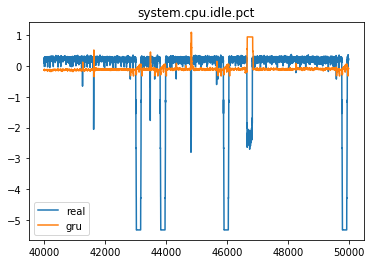

Mean Absolute Error :  0.7106940730102012


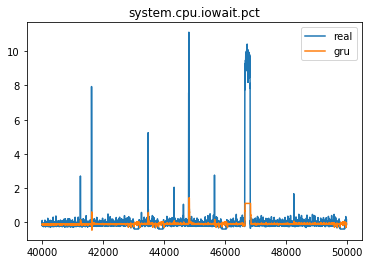

Mean Absolute Error :  0.2501336411115648


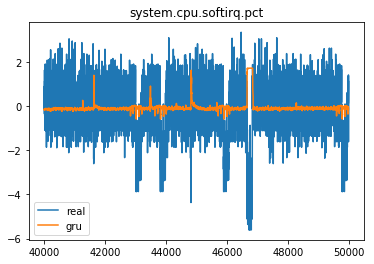

Mean Absolute Error :  0.8395928672810652


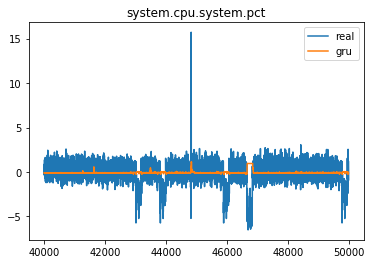

Mean Absolute Error :  0.8058111045223448


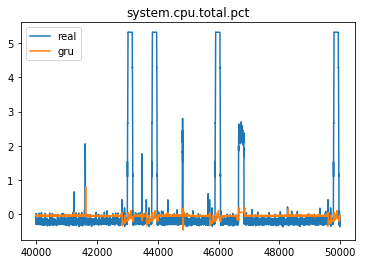

Mean Absolute Error :  0.5554667725062878


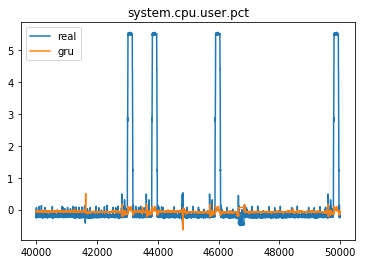

Mean Absolute Error :  0.4855707428146481


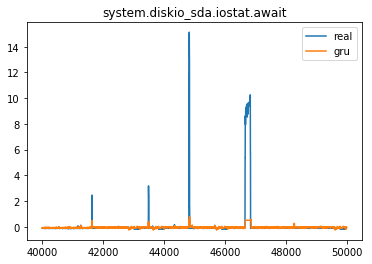

Mean Absolute Error :  0.23032806489443824


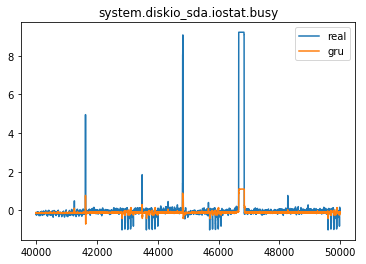

Mean Absolute Error :  0.2655654145780656


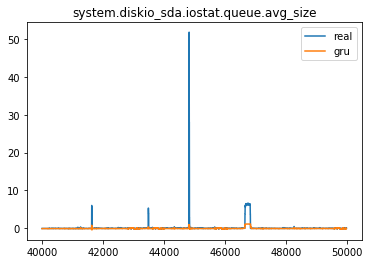

Mean Absolute Error :  0.21779192887628746


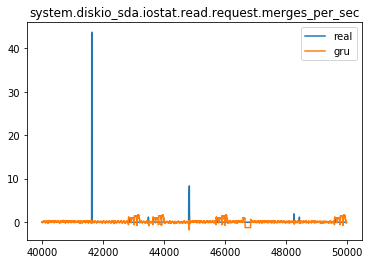

Mean Absolute Error :  0.32460805561722


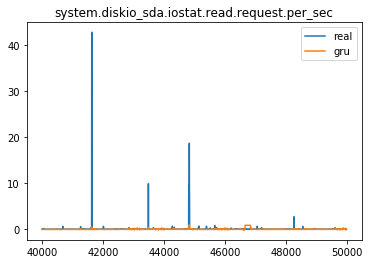

Mean Absolute Error :  0.1274381894795305


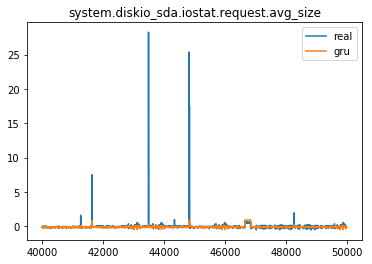

Mean Absolute Error :  0.16607775988718096


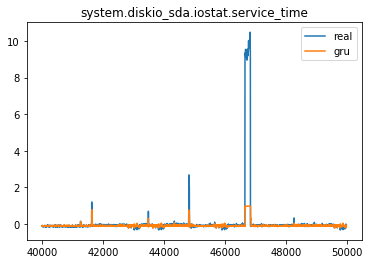

Mean Absolute Error :  0.19820461594325792


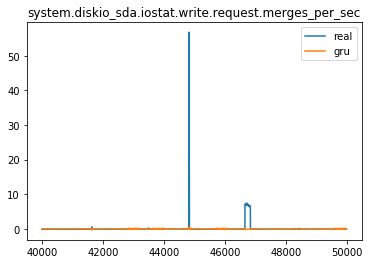

Mean Absolute Error :  0.25236703348468065


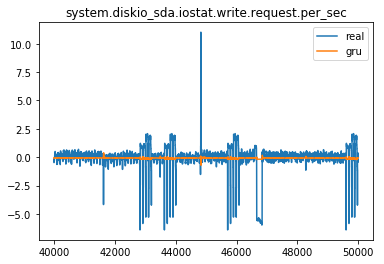

Mean Absolute Error :  0.5897152093332815


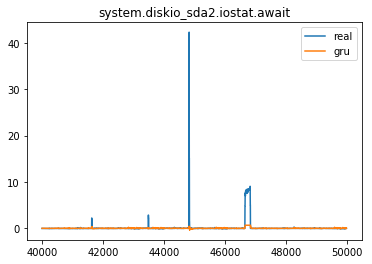

Mean Absolute Error :  0.21579363202893562


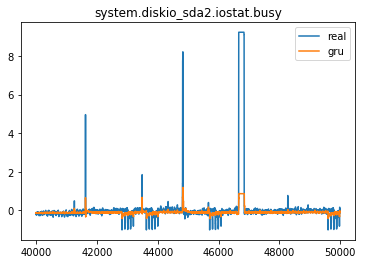

Mean Absolute Error :  0.2682727781807954


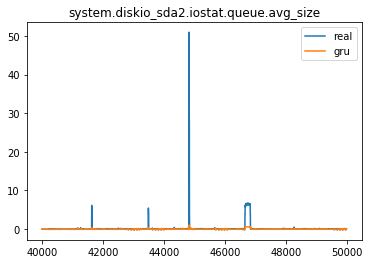

Mean Absolute Error :  0.23854270008852252


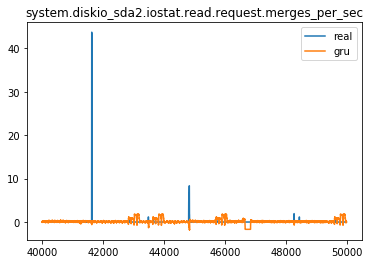

Mean Absolute Error :  0.34672645890889614


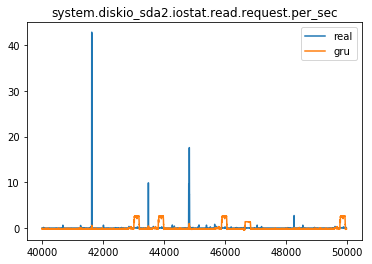

Mean Absolute Error :  0.40463340177551116


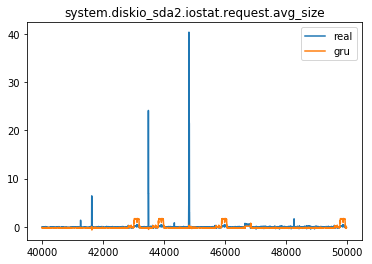

Mean Absolute Error :  0.30432383143337205


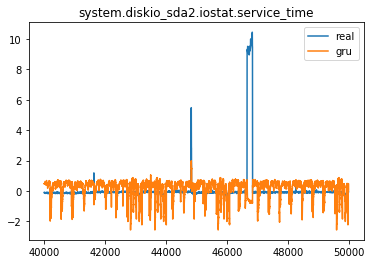

Mean Absolute Error :  0.7725729917800915


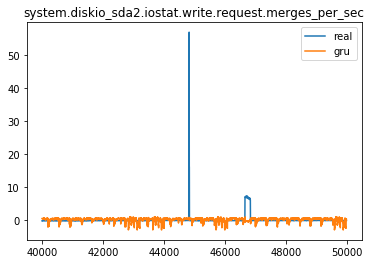

Mean Absolute Error :  0.7973659985444492


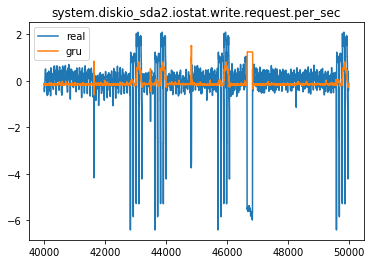

Mean Absolute Error :  0.6237125079690877


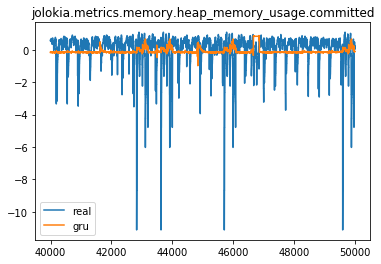

Mean Absolute Error :  0.8086530394080527


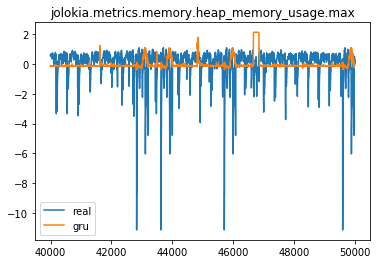

Mean Absolute Error :  0.8343605103020855


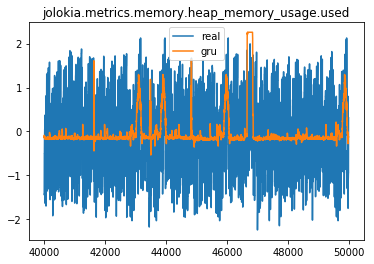

Mean Absolute Error :  0.8662343908579281


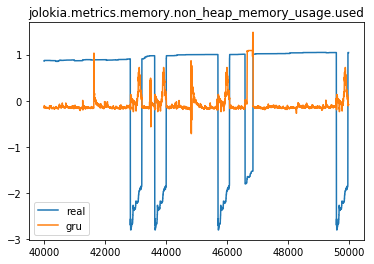

Mean Absolute Error :  1.3245569579033503


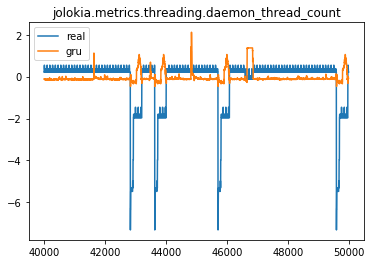

Mean Absolute Error :  0.7763671066574604


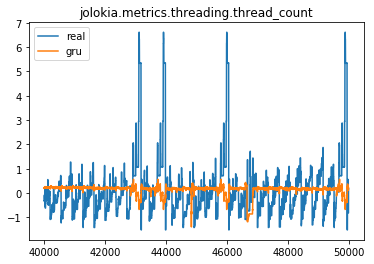

Mean Absolute Error :  0.8038056365423556


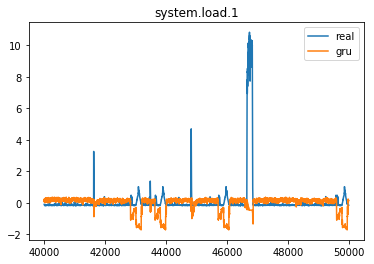

Mean Absolute Error :  0.5951383424094544


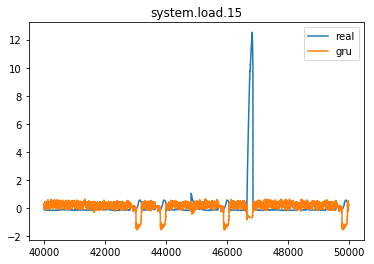

Mean Absolute Error :  0.5816604123916587


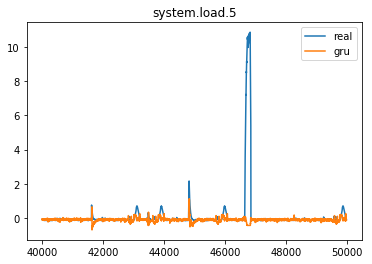

Mean Absolute Error :  0.2673676569741128


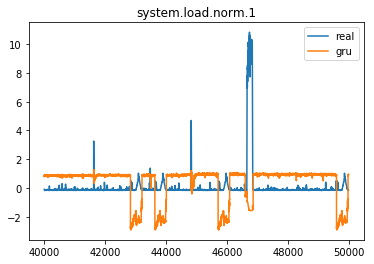

Mean Absolute Error :  1.4064625187070328


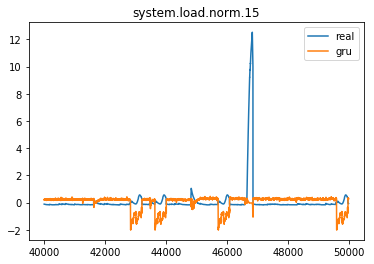

Mean Absolute Error :  0.666358342908426


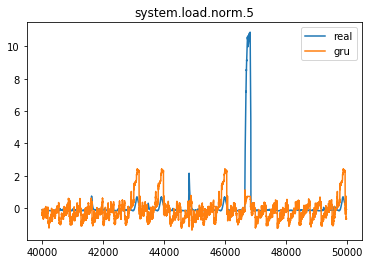

Mean Absolute Error :  0.6021554121214039


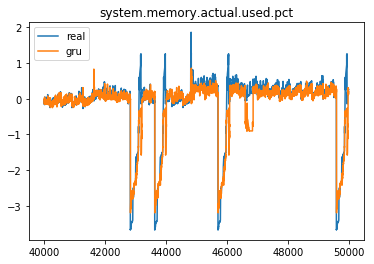

Mean Absolute Error :  0.19699250930951295


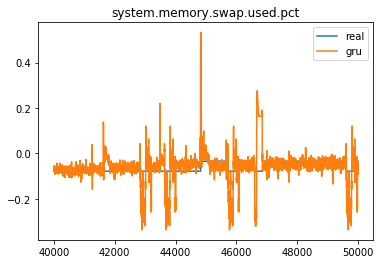

Mean Absolute Error :  0.037689812536261476


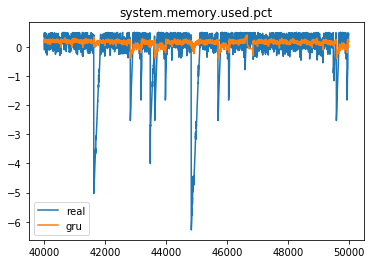

Mean Absolute Error :  0.38227197936678126


In [29]:
f = pyplot.figure()
for i in range(test_dataset_shifted.shape[1]):
    pyplot.plot(test_dataset_shifted[test_dataset_shifted.columns[i]], label='real')
    pyplot.plot(test_dataset_predicted_pd[test_dataset_predicted_pd.columns[i]], label='gru')
    pyplot.legend()
    pyplot.title(test_dataset_shifted.columns[i])
    pyplot.show()
    print("Mean Absolute Error : ",mean_absolute_error(test_dataset_shifted[test_dataset_shifted.columns[i]], test_dataset_predicted_pd[test_dataset_predicted_pd.columns[i]]))

## Saving Prediction

In [30]:
test_dataset_predicted_pd.to_csv("predicted_data.csv")

In [31]:
test_dataset.to_csv("test_data.csv")

In [32]:
test_dataset_shifted.to_csv("test_dataset_shifted.csv")